Script Name: ExamplePlot

Author: Fatemeh Delavari  
Version: 11.0 (10/13/2024) 

Description: Plots an example EEG containing complex partial seizure

In [18]:
import mne
import os
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from scipy.signal import hilbert, butter, filtfilt

In [19]:
# Specify the path to your EDF file
file_name = 'aaaaabnn_s002_t004.edf'
# folder_path = 'C:/Users/Atena/Documents/edf_files'
folder_path = 'C:/Users/Atena/Documents/edf_processed'
file_path = os.path.join(folder_path, file_name)

# Read the EDF file
raw = mne.io.read_raw_edf(file_path, preload=True)

# Get basic information
print(raw.info)
print(raw.ch_names)

sampfreq = int(raw.info['sfreq'])

# Extract signal data
data, times = raw[:]

print(f"Data shape: {data.shape}")
print(f"Times shape: {times.shape}")

Extracting EDF parameters from C:\Users\Atena\Documents\edf_processed\aaaaabnn_s002_t004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 121599  =      0.000 ...   303.998 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 128 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 200.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 nchan: 128
 projs: []
 sfreq: 400.0 Hz
 subject_info: <subject_info | his_id: aaaaabnn, sex: 1, last_name: aaaaabnn>
>
['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG EKG-REF', 'EEG 21-REF', 'EEG 22-REF', 'EEG T1-REF', 'EEG T2-REF', 'EEG 25-REF', 'EEG 26-REF', 'EEG 27-REF', 'EEG 28-REF', 'EEG 29-REF', 'EEG 3

In [3]:
# Define the channels you want to select
selected_channels = ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F7-REF', 'EEG F3-REF', 
                     'EEG FZ-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG T3-REF', 
                     'EEG C3-REF', 'EEG CZ-REF', 'EEG C4-REF', 'EEG T4-REF', 
                     'EEG T5-REF', 'EEG P3-REF', 'EEG PZ-REF', 'EEG P4-REF',
                     'EEG T6-REF', 'EEG O1-REF', 'EEG O2-REF']

raw_selected = raw.copy()
# Select the specified channels
raw_selected = raw_selected.pick_channels(selected_channels)

# Extract signal data for the selected channels
data, times = raw_selected[:]

print(f"Selected channels: {raw_selected.ch_names}")
print(f"Data shape: {data.shape}")
print(f"Times shape: {times.shape}")

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Selected channels: ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F7-REF', 'EEG F3-REF', 'EEG FZ-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG C3-REF', 'EEG CZ-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG P3-REF', 'EEG PZ-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O1-REF', 'EEG O2-REF']
Data shape: (19, 121600)
Times shape: (121600,)


In [20]:
simplified_names = ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4',
    'T5', 'T6', 'FZ', 'CZ', 'PZ']

In [5]:
# Define the seizure and background time intervals (in seconds)
seizure_start, seizure_end = 45, 181 
background_start_1, background_end_1 = 0, 44
background_start_2, background_end_2 = 182, 303

In [ ]:
preprocEEG = raw_selected.copy()

# Define the Butterworth filter parameters with filtfilt applied
iir_params = dict(order=6, ftype='butter', output='sos')

# Band-pass filter the data using a 6th-order Butterworth filter with filtfilt applied
preprocEEG.filter(l_freq=1.0, h_freq=50, method='iir', iir_params=iir_params, phase='zero')

preprocEEG.set_eeg_reference(ref_channels='average')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 24 (effective, after forward-backward)
- Cutoffs at 1.00, 50.00 Hz: -6.02, -6.02 dB

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | aaaaabnn_s002_t004.edf, 19 x 121600 (304.0 s), ~17.7 MiB, data loaded>

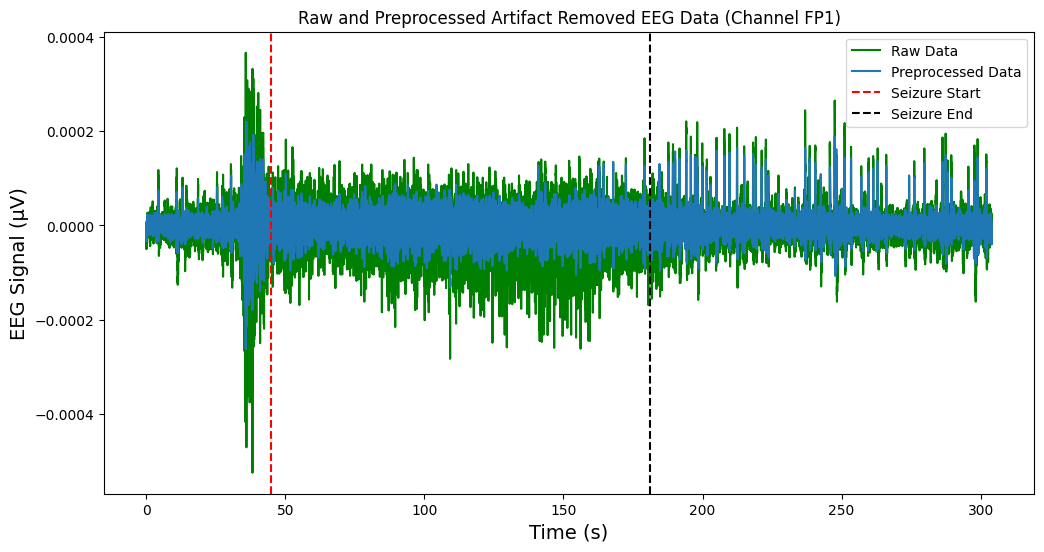

In [14]:
raw_data, raw_times = raw[:,:]
eegICA_data, eeg_times = preprocEEG[:,:]
# Comparison between raw and preprocessed artifact removed EEG
channel_idx = 0  # index of the channel you want to plot
plt.figure(figsize=(12, 6))
# You can keep adding more plots on the same figure this way
plt.plot(raw_times, raw_data[channel_idx, :], label='Raw Data', color='green')
plt.plot(raw_times, eegICA_data[channel_idx, :], label='Preprocessed Data')
plt.axvline(x=seizure_start, color='red', linestyle='--', label='Seizure Start')  # Adjusted for the new x-values
plt.axvline(x=seizure_end, color='black', linestyle='--', label='Seizure End')    # Adjusted for the new x-values
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('EEG Signal (µV)', fontsize=14)
plt.title(f'Raw and Preprocessed Artifact Removed EEG Data (Channel {simplified_names[channel_idx]})')
plt.legend()
plt.show()

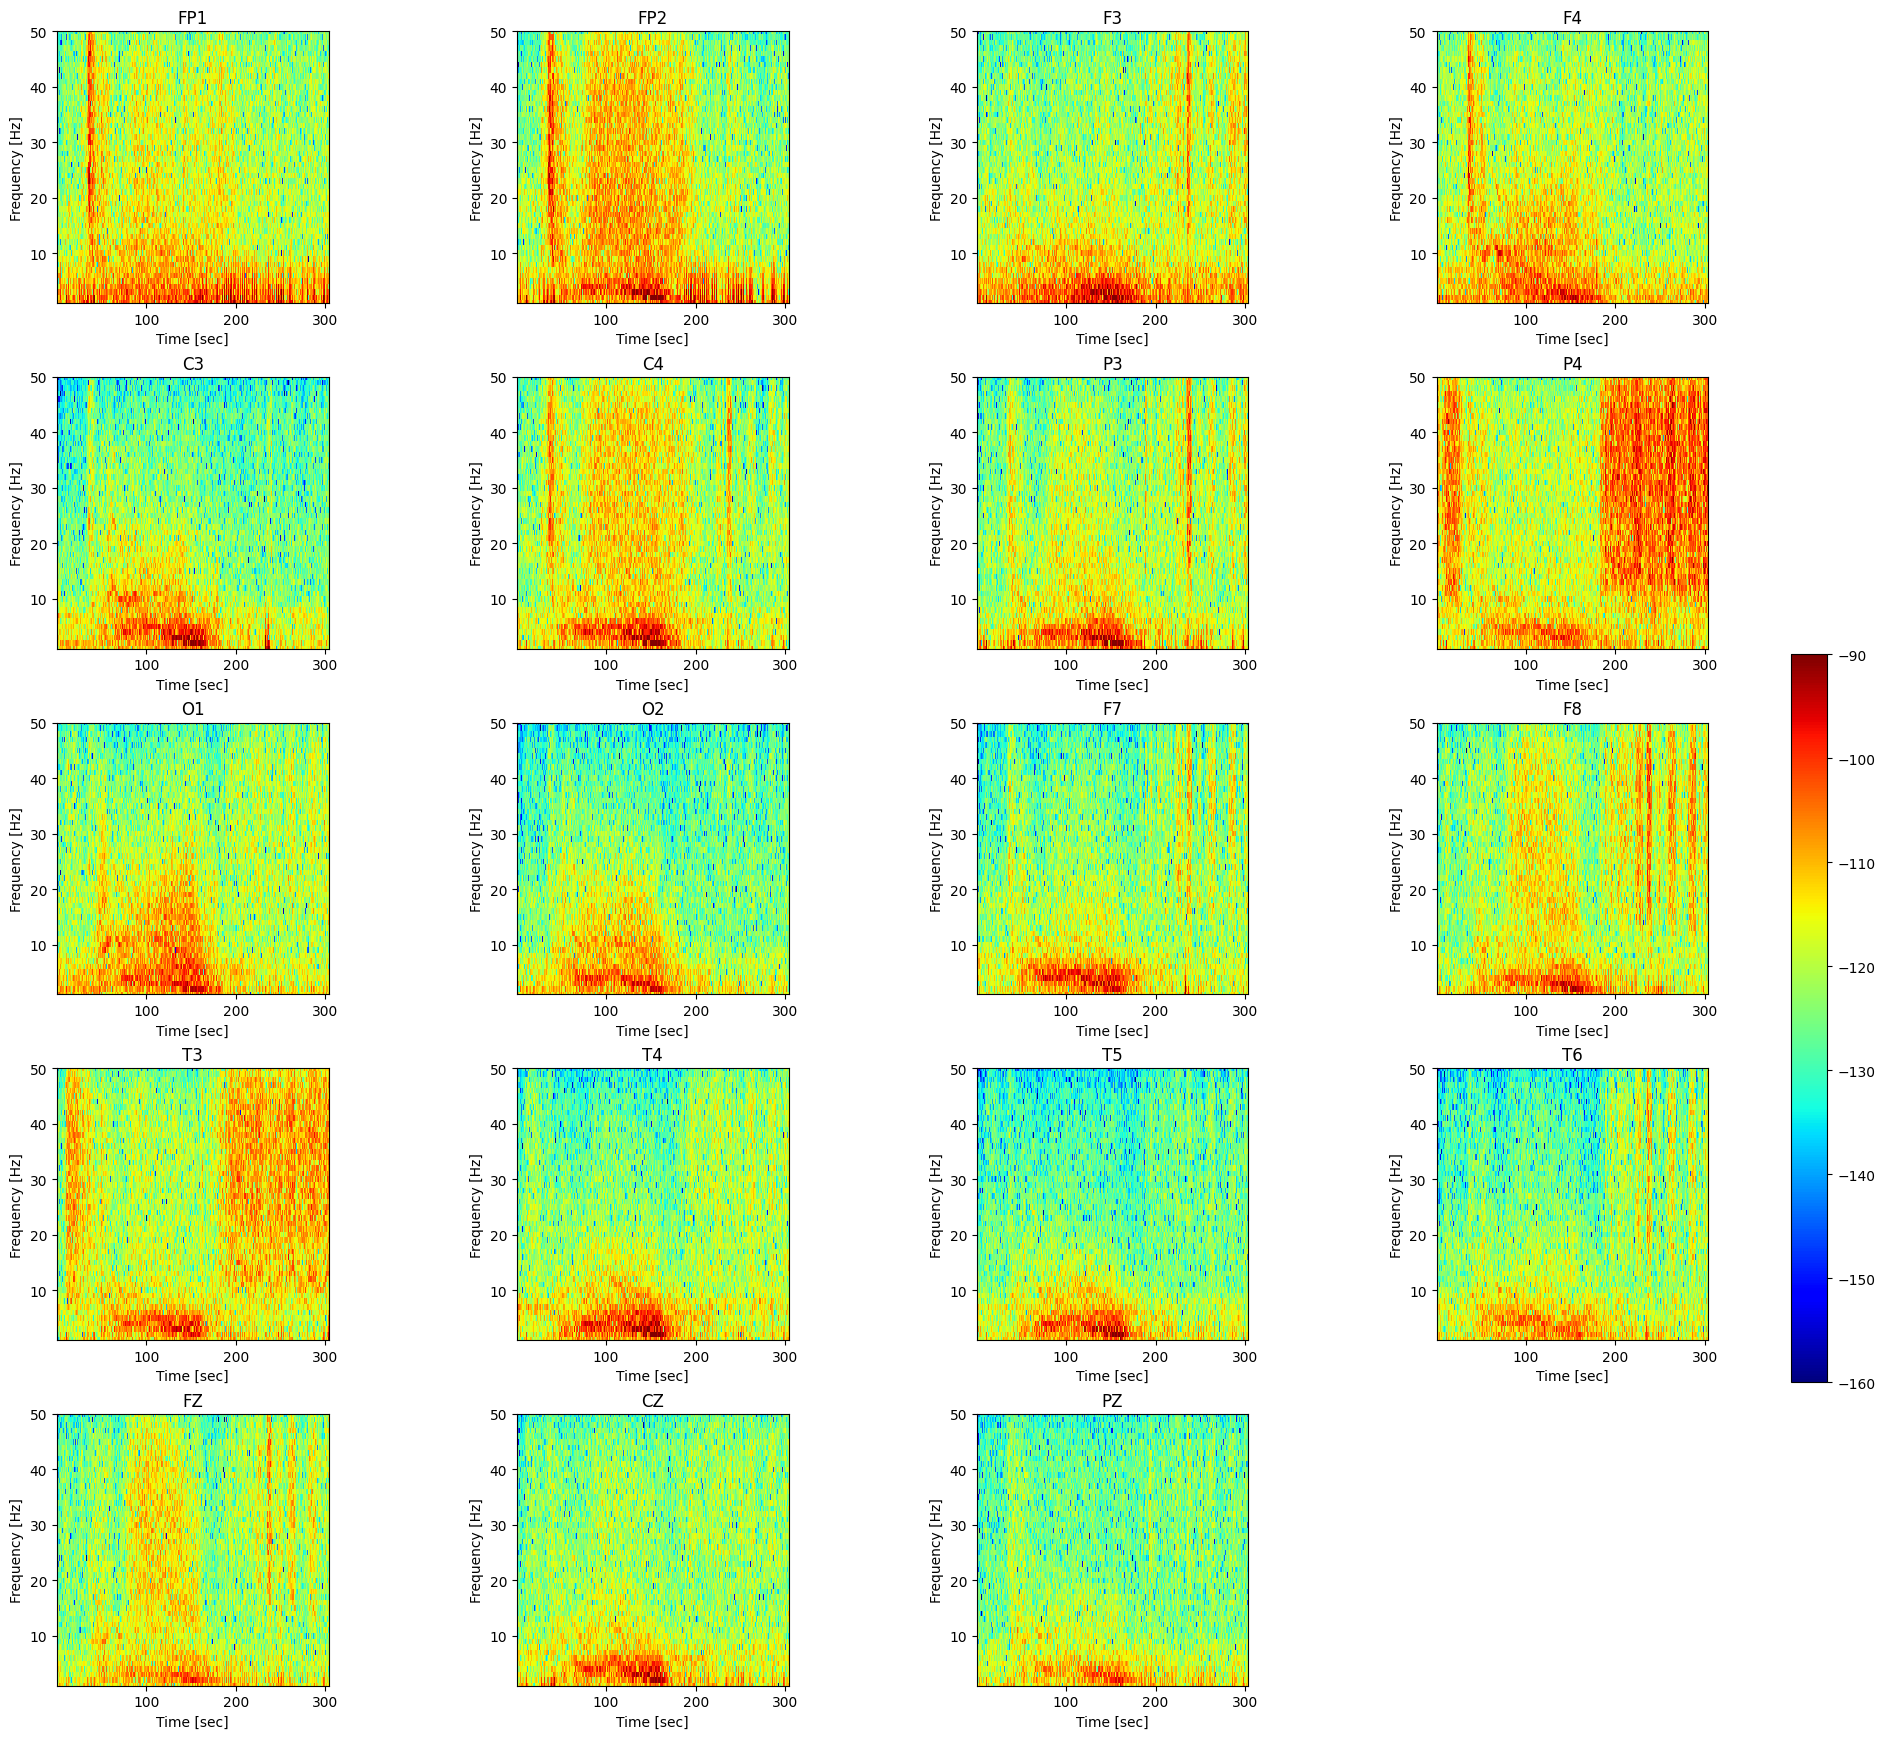

In [17]:
from scipy.signal import spectrogram

# Generate a sample signal (sine wave with two frequencies)
fs = sampfreq  # Sampling frequency (Hz)
# Extract signal data
data, times = preprocEEG[:, :]

# Parameters for the spectrogram
nperseg = fs  # Length of each segment (window length)
noverlap = fs//2  # Number of points to overlap between segments

nrows = 6
ncols = 4

num_channels = 19
# Create subplots for all channels
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 20), constrained_layout=True)
axes = axes.flatten()  # Flatten the axes for easier indexing

for i in range(num_channels):
    # Generate the spectrogram for each channel
    frequencies, times, Sxx = spectrogram(data[i],  fs, nperseg=nperseg, noverlap=noverlap)
    
    # Plot spectrogram for each channel
    img = axes[i].pcolormesh(times, frequencies, 10 * np.log10(Sxx), cmap = 'jet')

    # Set color limits
    img.set_clim(-160, -90)

    # axes[i].set_title(f'Channel {i+1}')
    axes[i].set_title(f'{simplified_names[i]}', fontsize=12)
    axes[i].set_ylabel('Frequency [Hz]')
    axes[i].set_xlabel('Time [sec]')
    axes[i].set_ylim(1, 50)  # Adjust based on your frequency range of interest
    axes[i].set_box_aspect(1)  # equivalent of 'Box' being 'on'

# Hide unused subplots if there are fewer channels than subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.colorbar(axes[0].collections[0], ax=axes, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()